# Zero-shot Learning

This is a self-contained notebook that examines the zero-shot performance capabilities of the fine-tuned CLIP model in the previous step.  

## Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [ ]:
! pip install optuna
! pip install ftfy regex tqdm optuna
! pip install git+https://github.com/ridvansalihkuzu/CLIP.git

In [1]:
import os
import glob

import clip
import torch

import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from collections import Counter
import scipy.cluster.hierarchy as shc
from sklearn.metrics import plot_confusion_matrix
#from sklearnex import patch_sklearn
#patch_sklearn()
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay,roc_curve
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from clip.downstream_task import TaskType 
import optuna
from optuna.samplers import TPESampler

%matplotlib inline

## Loading the Model

`clip.available_models()` will list the names of available CLIP models. 

In [2]:
available_models=clip.available_models()

The best performed pretrained model was `ViT-L/14` in the initial investigation at [01_a_clip_linear_probe_evaluation.ipynb](https://github.com/ridvansalihkuzu/CLIP/blob/main/01_a_clip_linear_probe_evaluation.ipynb).

Later, this `ViT-L/14` model has been fine-tuned as seen in [02_a_few_shot_training.py](https://github.com/ridvansalihkuzu/CLIP/blob/main/02_a_few_shot_training.py). 

You can download [the fine-tuned model](https://dl.dropboxusercontent.com/s/4ozx28ovrfc8t1z/selected_model_best.pth.tar?dl=0) and the replace the `best_model_path` below with your download location.

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#best_model_path='logs/selected_0.0001_-2_ARC_MLP_HEAD_model.pth.tar'
#best_model_path='logs/_0.00025_-1_ARC_MLP_HEAD_13_model_best.pth.tar'
best_model_path='logs/selected_model_best.pth.tar'

if os.path.exists(best_model_path):
    model, transform = clip.load(best_model_path,device,downstream_task=TaskType.ARC_MLP_HEAD,class_num=8)
else:
    print('WARNING: path is not found, default pretrained weights will be loaded!')
    model, transform = clip.load(available_models[-2],device)  #ViT-L/14

## Loading the Data

Training and test data are loaded below:

In [25]:
print("[INFO] Loading the training and test dataset...")
train_data_root_fw='data/coco_crops_few_shot/train'
test_data_root_fw='data/coco_crops_few_shot/test'
test_data_root_zr='data/coco_crops_zero_shot/test'

train_dataset_fw = ImageFolder(root=train_data_root_fw,transform=transform)
test_dataset_fw = ImageFolder(root=test_data_root_fw,transform=transform)
test_dataset_zr = ImageFolder(root=test_data_root_zr,transform=transform)
print("[INFO] Few shot training dataset contains {} samples.".format(len(train_dataset_fw)))
print("[INFO] Few shot test dataset contains {} samples.".format(len(test_dataset_fw)))
print("[INFO] Zero shot test dataset contains {} samples.".format(len(test_data_root_zr)))

[INFO] Loading the training and test dataset...
[INFO] Few shot training dataset contains 234 samples.
[INFO] Few shot test dataset contains 503 samples.
[INFO] Zero shot test dataset contains 30 samples.


## Extracting Features

By using `encode_image` function of the CLIP model, the train and test features are extracted as shown below:

In [26]:
def get_features(dataset, model, batch_size=32):
    '''
        THIS FUNCTION EXTRACTS THE FEATURES OF GIVEN IMAGES BY USING IMAGE_ENCODER METHOD OF THE GIVEN MODEL
        :param dataset: dataset object in ImageFolder type
        :param model: CLIP model to be exploited for feature extraction
        :param batch_size: the size of each batches in data reading
        :return: returns the tuple of (extracted features, labels)
    '''
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=batch_size)):
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

In [27]:
train_features_fw, _ = get_features(train_dataset_fw,model)
test_features_fw, _ = get_features(test_dataset_fw,model)
test_features_zr, _ = get_features(test_dataset_zr,model)


100%|██████████| 2/2 [00:26<00:00, 13.50s/it]


## Metrics to Measure the Performance of Novelty Detection in Zero-shot Learning

*Equal Error Rate*, *False Positive Rate* and *True Positive Rate* are some of the [common metrics](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) to measure the performance of a binary decision system. For this purpose, `compute_errors` function is provided below. 

*Density Distribution* of inliner and outlier scores are usually helpful to get some insight about the problem faced. That is why `plot_density` function below is provided.

In binary decisions (e.g. whether or not a sample is novel) *Detection Error Tradeoff Curve* is a common metric to observe the performance of a decision system.  For this purpose `plot_DET_with_EER` function is provided below.



In [77]:
def compute_errors(distances, labels):
    # Calculate evaluation metrics
    fprs, tprs, thresholds = roc_curve(labels, distances)
    fnrs = 1 - tprs
    fprs_opt = fprs[np.nanargmin(np.absolute(fnrs - fprs))]
    fnrs_opt = fnrs[np.nanargmin(np.absolute((fnrs - fprs)))]
    
    threshold=thresholds[np.where(fprs==fprs_opt)][0]
    
    return fprs, fnrs, fprs_opt, fnrs_opt, threshold


def plot_density(inlier_scores, outlier_scores,threshold):
    fig, ax = plt.subplots(figsize=(7,7))
    
    p1 = sns.distplot(inlier_scores, kde=True, norm_hist=False, bins=50, color="c", label="Inliers")
    p1 = sns.distplot(outlier_scores, kde=True, norm_hist=False, bins=50, color="m", label="Outliers")
   
    plt.axvline(x=threshold, color='b', ls='--', lw=1, label='EER boundary threshold = {0:0.2f}'.format(threshold))
    locs, labels = plt.yticks()
    plt.legend(labels=['Inliers (No-novelty)','Outliers (Novelty)','EER boundary threshold = {0:0.2f}'.format(threshold)])
    #plt.yticks(locs, list(map(str, locs * 0.01)))
    plt.ylabel('Density Distribution [%]', fontsize=18)
    plt.xlabel('Distance to Decision Boundary', fontsize=18)
    plt.title('Density Distribution for Novel and Non-novel Samples', fontsize=18)
    plt.grid(True)
    #fig.savefig('density_plot.jpg')
    
def plot_DET_with_EER(far, frr, far_optimum, frr_optimum):
    """ Plots a DET curve with the most suitable operating point based on threshold values"""
    fig, ax = plt.subplots(figsize=(7,7))
    # Plot the DET curve based on the FAR and FRR values
    plt.plot(far, frr, linestyle="-", linewidth=2, label="DET Curve")
    # Plot the optimum point on the DET Curve
    plt.plot(far_optimum,frr_optimum, "ro", label="Equal Error Rate = {0:0.3f}".format((far_optimum+frr_optimum)/2))

    # Draw the default DET Curve from 1-1
    #plt.plot([1.0,0.0], [0.0,1.0],"k--")
    plt.xlim([0.0, 0.9])
    plt.ylim([0.0, 0.9])
    plt.xlabel('False Positive Rate (False Novelty)',fontsize=18)
    plt.ylabel('False Negative Rate (False No-novelty)',fontsize=18)
    plt.title('Detection Error Tradeoff',fontsize=18)
    plt.legend(loc="upper right")
    plt.grid(True)
    #fig.savefig('DET_with_EER_plot.jpg')
    



## Fitting Novelty Estimator

There are various novelty estimation approaches in the literature, but here, our approach will rely on `LocalOutlierFactor`. To fit this estimator, the features of the training samples belonging to the `coco_crops_few_shot` dataset are utilized because we assume that the final *Novelty Estimator* is blind against the `coco_crops_zero_shot` samples. 


In [78]:
novelty_estimator = LocalOutlierFactor(n_neighbors=7,novelty=True)
novelty_estimator.fit(train_features_fw)

#novelty_estimator = IsolationForest(n_estimators=1000, warm_start=True)
#novelty_estimator.fit(train_features_fw)

LocalOutlierFactor(n_neighbors=7, novelty=True)

In the cell below, we are mixing the samples from both few-shot and zero-shot test folders in order to measure the robustness of our *Novelty Estimator*. This mixed data is exploited only for inference purposes and performance reporting against both novel and non-novel samples which are coming into the system as expected in the real-life scenario.

In [79]:
predicted_novelty_fw = -novelty_estimator.predict(test_features_fw) 
ground_truth_novelty_fw = -np.full(predicted_novelty_fw.shape, 1, dtype=int)

predicted_novelty_zr = -novelty_estimator.predict(test_features_zr)
ground_truth_novelty_zr= -np.full(predicted_novelty_zr.shape, -1, dtype=int)

scores_fw= -novelty_estimator.decision_function(test_features_fw)  #score_samples decision_function
scores_zr= -novelty_estimator.decision_function(test_features_zr)

## Performance Comparison in Novelty Detection



In [80]:
labels=np.concatenate([ground_truth_novelty_fw,ground_truth_novelty_zr])
preds=np.concatenate([predicted_novelty_fw,predicted_novelty_zr])
distances=np.concatenate([scores_fw,scores_zr])

fprs, fnrs, fprs_opt, fnrs_opt, threshold=compute_errors(distances, labels)
print('INFO: Equal Error Rate: {0:0.3f}'.format((fprs_opt+fnrs_opt)/2))

INFO: Equal Error Rate: 0.049


/p/software/juwelsbooster/stages/2022/software/Seaborn/0.11.2-gcccoremkl-11.2.0-2021.4.0/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/p/software/juwelsbooster/stages/2022/software/Seaborn/0.11.2-gcccoremkl-11.2.0-2021.4.0/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


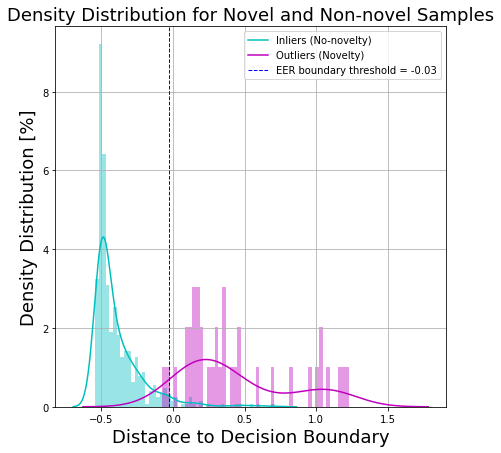

In [81]:
plot_density(scores_fw, scores_zr,threshold)

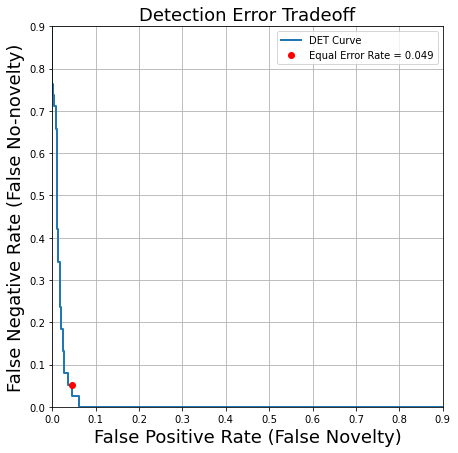

In [82]:
plot_DET_with_EER(fprs, fnrs, fprs_opt, fnrs_opt)

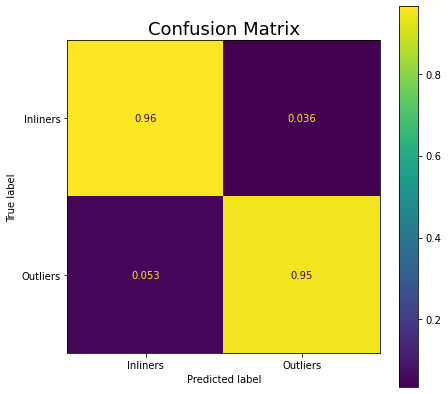

In [84]:
fig, ax = plt.subplots(figsize=(7,7))

ax.set_title("Confusion Matrix",fontsize=18)
cm = confusion_matrix(labels, preds,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Inliners', 'Outliers'])
disp.plot(ax=ax)

#fig.savefig('Confusion_matrix_plot.jpg')

## Iterative Updates on Novel Observations

If the *Novelty Detection Model* returns `TRUE` specifying the system found a new object to extend the database. Furthermore, in the real scenario, when those new objects get accumulated to a certain volume, the database may include not a single but multiple new categories. That is why
*Hierarchical Clustering* based on [AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) has been also placed below as well. The hierarchical clustering is a buttom up clustering approach, treating each samples as seperate cluster initially and merging the closest samples iteratively to reach larger clusters. 

In other words, *Hierarchical Clustering* can be periodically run in order to observe the volume changes in the `dendogram` of the novel points: in this way, potential new categories of interest can be pre-determined.

The above explained scenario has been investigated in the cells below:



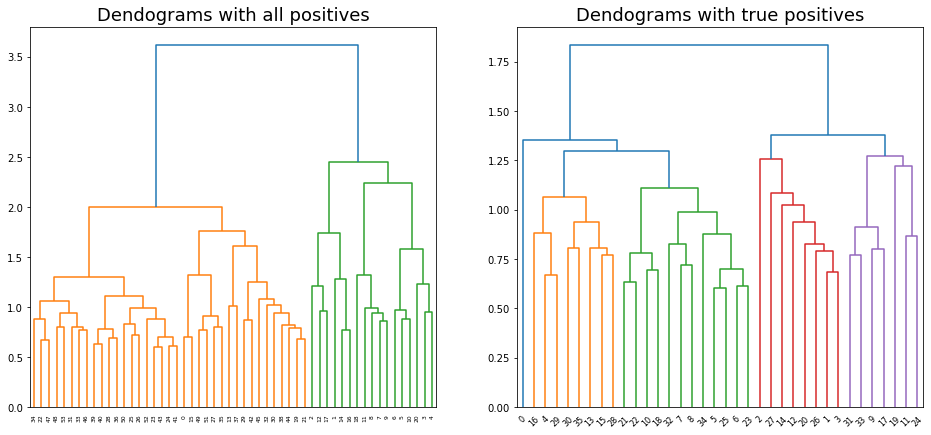

In [69]:
false_positive_indices = np.where(predicted_novelty_fw == 1)
true_positive_indices = np.where(predicted_novelty_zr == 1)

all_postive_indices = np.where(preds==1)



dendogram_input=np.concatenate([test_features_fw[false_positive_indices],test_features_zr[true_positive_indices]])

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,7))
ax1.set_title("Dendograms with all positives",fontsize=18)
dend = shc.dendrogram(shc.linkage(dendogram_input, method='ward'),ax=ax1)

ax2.set_title("Dendograms with true positives",fontsize=18)
dend = shc.dendrogram(shc.linkage(test_features_zr[true_positive_indices], method='ward'),ax=ax2)

#fig.savefig('dendograms.jpg')

In [74]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph


print("Compute structured hierarchical clustering...")
n_clusters = 3  # number of regions
knn_graph = kneighbors_graph(test_features_zr[true_positive_indices], 30, include_self=True)
clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward",connectivity=knn_graph)
clustering.fit(test_features_zr[true_positive_indices])


Compute structured hierarchical clustering...


AgglomerativeClustering(connectivity=<36x36 sparse matrix of type '<class 'numpy.float64'>'
	with 1080 stored elements in Compressed Sparse Row format>,
                        n_clusters=3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

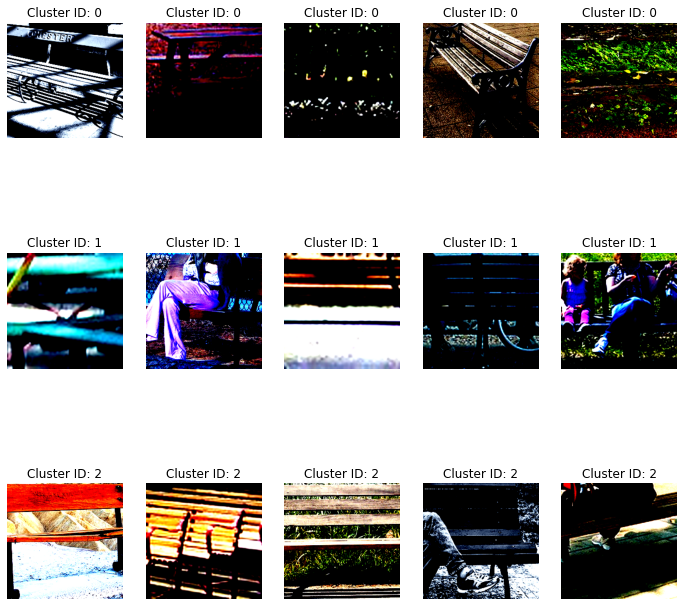

In [76]:
#files=glob.glob(test_data_root_zr+'/*/*.jpg')
fig, axarr = plt.subplots(n_clusters,5,figsize=(12, 12))
for cl in range(n_clusters):
    cluster_ind=np.where(clustering.labels_==cl)
    tp_cluster_ind=true_positive_indices[0][cluster_ind]
    for idx1,idx2 in enumerate(tp_cluster_ind[:5]):
        axarr[cl,idx1].imshow(test_dataset_zr[idx2][0].permute(1, 2, 0))
        #axarr[idx1].imshow(mpimg.imread(files[idx2]))
        axarr[cl,idx1].axis('off')
        axarr[cl,idx1].set_title('Cluster ID: {}'.format(cl))

#fig.savefig('cluster_examples.jpg')